In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy
import os
import platform
%matplotlib inline

In [7]:
class KMeans:
    
    def __init__(self,dictionary):
        self.X_train = list()
        self.y_train = list() 
        self.X_test  = list()
        self.y_test  = list()
        self.X_train_x = list()
        self.y_train_x = list()
        self.num_folds = dictionary['num_folds'] 
        self.k_choices = dictionary['k_choices']
        self.data_dir = dictionary['data_dir']
        self.n_clusters = 10  #Default value of the clusters
        self.max_iter = 100
        self.loss_per_iteration = []

    def load_pickle(self, f):
        version = platform.python_version_tuple()
        if version[0] == '2':
            return  pickle.load(f)
        elif version[0] == '3':
            return  pickle.load(f, encoding='latin1')
        raise ValueError("invalid python version: {}".format(version))

    def load_CIFAR_batch(self, filename):
        with open(filename, 'rb') as f:
            datadict = self.load_pickle(f)
            X = datadict['data']
            Y = datadict['labels']
            X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
            Y = np.array(Y)
            return X, Y

    def load_CIFAR10(self, ROOT):
        xs = []
        ys = []
        for b in range(1,6):
            f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
            X, Y = self.load_CIFAR_batch(f)
            xs.append(X)
            ys.append(Y)    
        Xtr = np.concatenate(xs)
        Ytr = np.concatenate(ys)
        del X, Y
        Xte, Yte = self.load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
        return Xtr/255.0, Ytr, Xte/255.0, Yte
    
    def loadData(self):
        
        self.X_train, self.y_train, self.X_test, self.y_test = self.load_CIFAR10(self.data_dir)
        
        print('Training data shape: ', self.X_train.shape)
        print('Training labels shape: ', self.y_train.shape)
        print('Test data shape: ', self.X_test.shape)
        print('Test labels shape: ', self.y_test.shape)
        
    def visualize(self):
        classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        num_classes = len(classes)
        samples_per_class = 7
        for y, cls in enumerate(classes):
            idxs = np.flatnonzero(self.y_train == y)
            idxs = np.random.choice(idxs, samples_per_class, replace=False)
            for i, idx in enumerate(idxs):
                plt_idx = i * num_classes + y + 1
                plt.subplot(samples_per_class, num_classes, plt_idx)
                plt.imshow(self.X_train[idx])
                plt.axis('off')
                if i == 0:
                    plt.title(cls)
        plt.show()
    
    def init_centroids(self):
        np.random.seed(np.random.randint(0,100000))
        self.centroids = []
        for i in range(self.n_clusters):
            rand_index = np.random.choice(range(len(self.fit_data)))
            self.centroids.append(self.fit_data[rand_index])
    
    def init_clusters(self):
        self.clusters = {'data':{i:[] for i in range(self.n_clusters)}}
        self.clusters['labels']={i:[] for i in range(self.n_clusters)}

    def fit(self,fit_data,fit_labels, n_clusters):
        self.n_clusters = n_clusters
        self.fit_data = np.copy(fit_data)
        self.fit_labels = np.copy(fit_labels)
        self.predicted_labels = [None for _ in range(self.fit_data.shape[0])]
        self.init_centroids()
        self.iterations = 0
        old_centroids = [np.zeros(shape=(fit_data.shape[1],)) for _ in range(self.n_clusters)]
        while not self.converged(self.iterations,old_centroids,self.centroids):
            old_centroids = copy.deepcopy(self.centroids)
            self.init_clusters()
            for j,sample in (enumerate(self.fit_data)):
                min_dist = float('inf')
                for i,centroid in enumerate(self.centroids):
                    dist = np.linalg.norm(sample-centroid)
                    if dist<min_dist:
                        min_dist = dist
                        self.predicted_labels[j] = i
                if self.predicted_labels[j] is not None:
                        self.clusters['data'][self.predicted_labels[j]].append(sample)                    
                        self.clusters['labels'][self.predicted_labels[j]].append(self.fit_labels[j])
            self.reshape_cluster()
            self.update_centroids()
            self.calculate_loss()
#             print("\nIteration:",self.iterations,'Loss:',self.loss,'Difference:',self.centroids_dist)
            self.iterations+=1
        self.calculate_accuracy()
        
    
    def update_centroids(self):
        for i in range(self.n_clusters):
            cluster = self.clusters['data'][i]
            if len(cluster) == 0:
                self.centroids[i] = self.fit_data[np.random.choice(range(len(self.fit_data)))]
            else:
                self.centroids[i] = np.mean(np.vstack((self.centroids[i],cluster)),axis=0)
    
    def reshape_cluster(self):
        for id,mat in list(self.clusters['data'].items()):
            self.clusters['data'][id] = np.array(mat)

    def converged(self,iterations,centroids,updated_centroids):
        if iterations > self.max_iter:
            return True
        self.centroids_dist = np.linalg.norm(np.array(updated_centroids)-np.array(centroids))
        if self.centroids_dist<=1e-10:
#             print("Converged! With distance:",self.centroids_dist)
            return True
        return False

    def calculate_loss(self):
        self.loss = 0
        for key,value in list(self.clusters['data'].items()):
            if value is not None:
                for v in value:
                    self.loss += np.linalg.norm(v-self.centroids[key])
        self.loss_per_iteration.append(self.loss)
    
    def calculate_accuracy(self):
        self.clusters_labels = []
        self.clusters_info = []
        self.clusters_accuracy = []
        for clust,labels in list(self.clusters['labels'].items()):
            if isinstance(labels[0],(np.ndarray)):
                labels = [l[0] for l in labels]
            occur = 0
            max_label = max(set(labels), key=labels.count)
            self.clusters_labels.append(max_label)
            for label in labels:
                if label == max_label:
                    occur+=1
            acc = occur/len(list(labels))
            self.clusters_info.append([max_label,occur,len(list(labels)),acc])
            self.clusters_accuracy.append(acc)
            self.accuracy = sum(self.clusters_accuracy)/self.n_clusters
        self.labels_ = []
        for i in range(len(self.predicted_labels)):
            self.labels_.append(self.clusters_labels[self.predicted_labels[i]])
#         print('[cluster_label,no_occurence_of_label,total_samples_in_cluster,cluster_accuracy]',self.clusters_info)
#         print('Accuracy:',self.accuracy)
        
    def test(self, X, y):

        self.predicted_label = [None for _ in range(X.shape[0])]
        for j,sample in (enumerate(X)):
                min_dist = float('inf')
                for i,centroid in enumerate(self.centroids):
                    dist = np.linalg.norm(sample-centroid)
                    
                    if dist<min_dist:
                        min_dist = dist
                        self.predicted_label[j] = self.clusters_info[i][0]
        
        acc = 0
        for i in range(len(y)):
            if y[i] == self.predicted_label[i]:
                acc = acc + 1
        
        return acc/len(y)
        
    def crossValidation(self):
        
        num_folds = self.num_folds
        k_choices = self.k_choices

        X_train_folds = []
        y_train_folds = []
        
        num_training = 50000
        mask = list(range(num_training))
        X_train = np.copy(self.X_train[mask])
        y_train = np.copy(self.y_train[mask])

        num_test = 10000
        mask = list(range(num_test))
        X_test = np.copy(self.X_test[mask])
        y_test = np.copy(self.y_test[mask])

        X_train = np.reshape(X_train, (X_train.shape[0], -1))
        X_test = np.reshape(X_test, (X_test.shape[0], -1))
#         print(X_train.shape, X_test.shape)
        

        X_train_folds = np.array_split(X_train,num_folds)
        y_train_folds = np.array_split(y_train,num_folds)
        k_to_accuracies = {}
        
        print("Printing our 5-fold accuracies for varying values of k:")
        print()
        
        for k in k_choices:
            k_to_accuracies[k] = []
            self.n_clusters = k
            for num_knn in range(0,num_folds):
                X_test = X_train_folds[num_knn]
                y_test = y_train_folds[num_knn]
                X_train = X_train_folds
                y_train = y_train_folds

                temp = np.delete(X_train,num_knn,0)
                X_train = np.concatenate((temp),axis = 0)
                y_train = np.delete(y_train,num_knn,0)
                y_train = np.concatenate((y_train),axis = 0)

                self.fit(X_train, y_train, k)

                accuracy = self.test(X_test, y_test)
                
                k_to_accuracies[k].append(accuracy)
                print('k = %d, accuracy = %f' % (k, accuracy))


        print('+----------------------------------------------+')
        for k in sorted(k_to_accuracies):
            avg = 0
            for accuracy in k_to_accuracies[k]:
                print('k = %d, accuracy = %f' % (k, accuracy))
                avg = avg + accuracy
                
            print('k = %d, average accuracy =%f'% (k, avg / num_folds))
            print()


In [3]:
dictionary = {'num_folds' : 5,
             'k_choices' : [3, 5, 7, 11],
             'data_dir' : './data/cifar-10-batches-py'}

In [4]:
kmeans = KMeans(dictionary)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


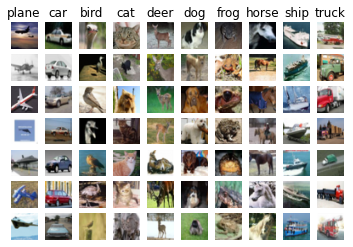

In [5]:
kmeans.loadData()
kmeans.visualize()

In [6]:
kmeans.crossValidation()

Printing our 5-fold accuracies for varying values of k:

k = 3, accuracy = 0.183000
k = 3, accuracy = 0.170200
k = 3, accuracy = 0.179800
k = 3, accuracy = 0.172400
k = 3, accuracy = 0.178700
k = 5, accuracy = 0.194200
k = 5, accuracy = 0.184400
k = 5, accuracy = 0.187800
k = 5, accuracy = 0.185400
k = 5, accuracy = 0.192000
k = 7, accuracy = 0.203900
k = 7, accuracy = 0.187300
k = 7, accuracy = 0.194600
k = 7, accuracy = 0.190600
k = 7, accuracy = 0.198800
k = 11, accuracy = 0.228600
k = 11, accuracy = 0.224000
k = 11, accuracy = 0.227200
k = 11, accuracy = 0.223300
k = 11, accuracy = 0.236500
k = 3, accuracy = 0.183000
k = 3, accuracy = 0.170200
k = 3, accuracy = 0.179800
k = 3, accuracy = 0.172400
k = 3, accuracy = 0.178700
k = 3, average accuracy =0.176820

k = 5, accuracy = 0.194200
k = 5, accuracy = 0.184400
k = 5, accuracy = 0.187800
k = 5, accuracy = 0.185400
k = 5, accuracy = 0.192000
k = 5, average accuracy =0.188760

k = 7, accuracy = 0.203900
k = 7, accuracy = 0.187300
k = 